<a href="https://colab.research.google.com/github/galhagag/computer-vision-age-prediction/blob/master/age_prediction_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Prediction

I'll use computer vision to help a supermarket chain processing customer photos.

Photofixation in the checkout area will help determine the age of customers in order to:
* Analyze purchases and offer products that may interest buyers in particular age groups
* Monitor clerks selling alcohol

# Importing Data

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
labels = pd.read_csv('/content/drive/My Drive/Data Science/Computer Vision Project/labels.csv')

In [3]:
directory = '/content/drive/My Drive/Data Science/Computer Vision Project/datasets/faces/final_files/'

In [4]:
datagen = ImageDataGenerator(rescale=1./255) # rescaling values of pixels for better performance in NN
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), # reshaping photos
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
features, target = next(datagen_flow)

In [6]:
features.shape

(32, 224, 224, 3)

* The dataset contain 7,591 pictures.
* The first batch consist of 32 photos in the shape of 224x224 pixels and 3 channels (RGB).
* Let's look at some of the pictures.

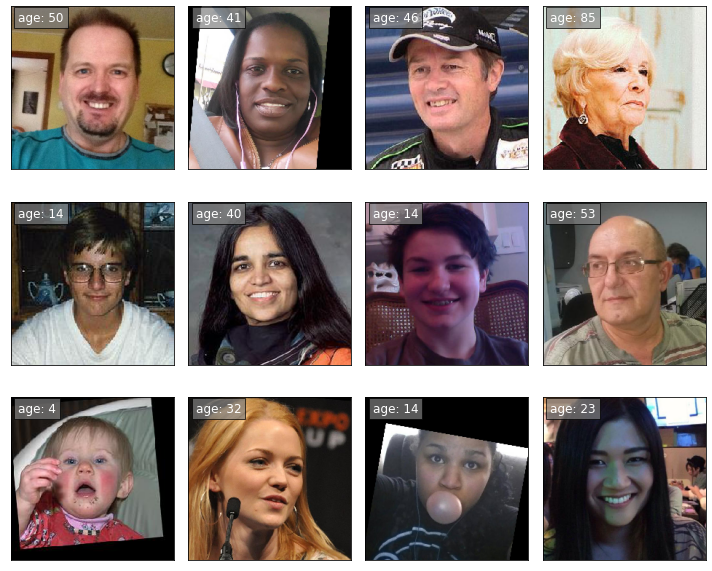

In [7]:
fig = plt.figure(figsize=(10,9))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.text(10, 20, f'age: {target[i]}', color='white', fontsize=12,
            bbox=dict(facecolor='gray', edgecolor='k', alpha=0.7))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

* Photos taken in different lightning, some rotated and facing two sides.
* I'll apply use data augmentation techniques to better represent the data and enrich the training set.
* I'll split the data to train-validation sets (80%/20% respectively)

# Spliting to Train \ Validation sets

Applying data augmentation on the train set alone.

In [8]:
# using same seeds in order to prevent the training and validation sets from sharing common elements

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15,
                                   rotation_range=0.3,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=(0.5,1.5),
                                   horizontal_flip=True)

train_gen_flow = train_datagen.flow_from_dataframe(
                                                    dataframe=labels,
                                                    directory=directory,
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224), 
                                                    batch_size=32,
                                                    class_mode='raw',
                                                    subset='training',
                                                    seed=12345)

valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15)

valid_gen_flow = valid_datagen.flow_from_dataframe(
                                                    dataframe=labels,
                                                    directory=directory,
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    seed=12345)

Found 6453 validated image filenames.
Found 1138 validated image filenames.


## EDA

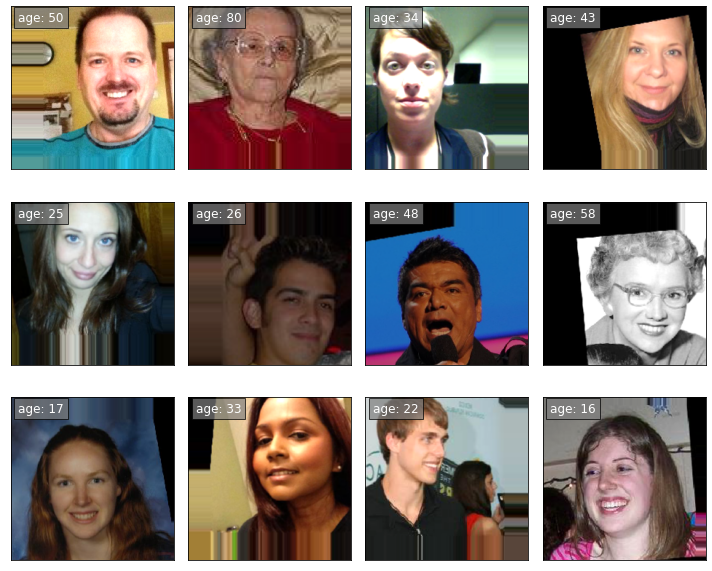

In [9]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,9))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.text(10, 20, f'age: {target[i]}', color='white', fontsize=12,
            bbox=dict(facecolor='gray', edgecolor='k', alpha=0.7))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Note: The smeared photos have been modified and the missing pixels were filled with the `nearest` ones (can be modified using `fill_mode` hyperparameter)

## Target Distribution

In [10]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

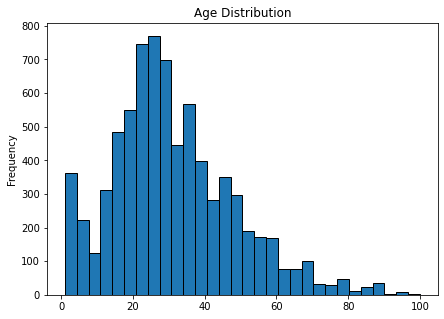

In [11]:
labels.real_age.plot(kind='hist', bins=30, edgecolor='k', title='Age Distribution', figsize=(7,5))
plt.show()

The age ditsribution is right skewed. Let's look at the pictures in the extreme

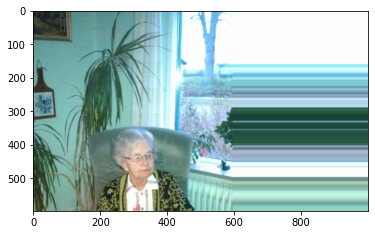

In [12]:
# oldest person - 100 years old

file_name = labels.loc[labels.real_age.argmax(),'file_name']
image = Image.open(directory + file_name)
plt.imshow(image)
plt.show()

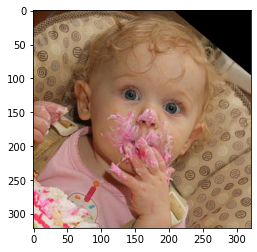

In [13]:
# youngest baby - 1 years old

file_name = labels.loc[labels.real_age.argmin(),'file_name']
image = Image.open(directory + file_name)
plt.imshow(image)
plt.show()

The raw pictures are in different sizes but it was handled in the data generator

# Modeling

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

## CNN

In [15]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(3,3), padding='same',
                              activation='relu', input_shape=(224, 224,3)))
model.add(AvgPool2D(pool_size=(2,2)))
model.add(Conv2D(12, kernel_size=(3,3), padding='valid',
                              activation='relu'))
model.add(AvgPool2D(pool_size=(2,2)))
model.add(Conv2D(24, kernel_size=(3,3), padding='valid',
                              activation='relu'))
model.add(AvgPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1,  activation='relu'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 6)       168       
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 12)      660       
_________________________________________________________________
average_pooling2d_1 (Average (None, 55, 55, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 24)        2616      
_________________________________________________________________
average_pooling2d_2 (Average (None, 26, 26, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16224)             0

In [16]:
%%time

callback = EarlyStopping(monitor='loss', patience=5)
history = model.fit(train_gen_flow,
                    validation_data=valid_gen_flow,
                    steps_per_epoch=len(train_gen_flow),
                    validation_steps=len(valid_gen_flow),
                    callbacks=[callback],
                    verbose=2, epochs=50)

Epoch 1/50
202/202 - 6112s - loss: 436.4543 - mae: 16.0306 - val_loss: 295.6176 - val_mae: 14.0370
Epoch 2/50
202/202 - 135s - loss: 295.1046 - mae: 13.2841 - val_loss: 268.2495 - val_mae: 12.9146
Epoch 3/50
202/202 - 135s - loss: 291.1248 - mae: 13.1696 - val_loss: 268.6423 - val_mae: 13.0765
Epoch 4/50
202/202 - 134s - loss: 286.1914 - mae: 13.0888 - val_loss: 279.1150 - val_mae: 13.6253
Epoch 5/50
202/202 - 134s - loss: 283.6564 - mae: 13.0342 - val_loss: 256.5746 - val_mae: 12.5013
Epoch 6/50
202/202 - 135s - loss: 285.0273 - mae: 13.0859 - val_loss: 263.3217 - val_mae: 13.0295
Epoch 7/50
202/202 - 135s - loss: 281.1745 - mae: 12.9861 - val_loss: 253.6557 - val_mae: 12.3237
Epoch 8/50
202/202 - 135s - loss: 283.3663 - mae: 12.9857 - val_loss: 258.2907 - val_mae: 12.8062
Epoch 9/50
202/202 - 132s - loss: 280.9911 - mae: 12.9998 - val_loss: 283.4697 - val_mae: 13.8577
Epoch 10/50
202/202 - 133s - loss: 280.0031 - mae: 12.9859 - val_loss: 267.5952 - val_mae: 13.2701
Epoch 11/50
202/20

In [17]:
training_hist = pd.DataFrame(history.history)
training_hist['rmse'] = training_hist['loss'].apply(np.sqrt)
training_hist['val_rmse'] = training_hist['val_loss'].apply(np.sqrt)

In [18]:
training_hist.tail()

,loss,mae,val_loss,val_mae,rmse,val_rmse
27,273.296875,12.822274,266.955780,13.322334,16.531693,16.338781
28,271.816986,12.764947,249.303940,12.595200,16.486873,15.789362
29,271.785828,12.769272,249.985031,12.653902,16.485928,15.810915
30,273.373291,12.801358,262.919098,13.164368,16.534004,16.214780
31,271.109497,12.767382,242.938019,12.241186,16.465403,15.586469


MAE is about 13 and RMSE is 16, meaning the model have some exreme errors.

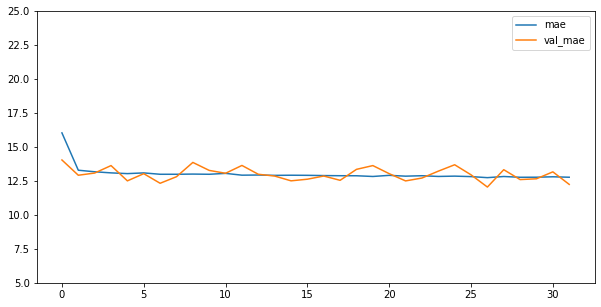

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

training_hist[['mae','val_mae']].plot(kind='line', ax=ax, label=('train','test'), ylim=(5,25))
plt.show()

Training on the available data get a score of about 12 MAE. 
I'll try to beat it using transfer learning.

# Transfor Learning

* I'll use ResNet50 as pre-trained model for prediction.
* ResNet50 was train on ImageNet dataset to classify 1000 different classes of images.
* The architect of the network is as following. I'll remove the last 2 layers and add new ones to modify it to the new task of predicting people ages.
* I'll use it's initial weights but allow their change in training epochs.

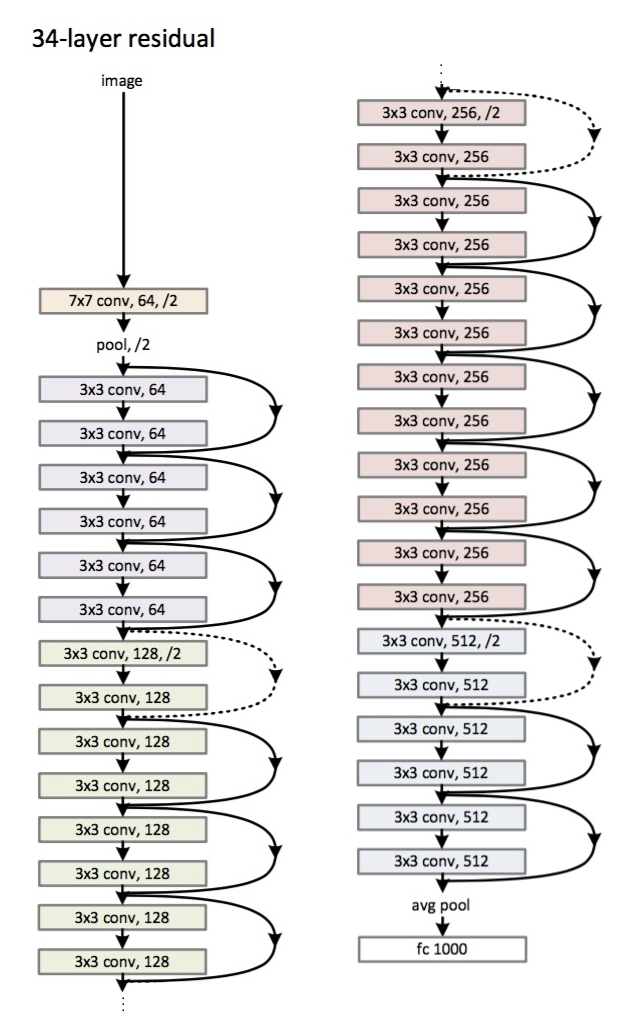

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50

In [21]:
backbone = ResNet50(input_shape=(224, 224,3),
                    weights='imagenet', 
                    include_top=False)


model2 = Sequential()
model2.add(backbone)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(128,  activation='relu'))
model2.add(Dense(64,  activation='relu'))
model2.add(Dense(1,  activation='relu'))

opt = Adam(lr=1e-5)
model2.compile(optimizer=opt, 
              loss='mse',
              metrics=['mae'])

model2.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 23,858,305
Trainable params: 23,805,185
Non-trainable params: 53,120
_________________________________________________________________


In [22]:
%%time
history2 = model2.fit(train_gen_flow,
                      validation_data=valid_gen_flow,
                      steps_per_epoch=len(train_gen_flow),
                      validation_steps=len(valid_gen_flow),
                      verbose=2, epochs=15)

Epoch 1/15
202/202 - 189s - loss: 784.8793 - mae: 23.1800 - val_loss: 1074.6981 - val_mae: 28.2401
Epoch 2/15
202/202 - 186s - loss: 157.1906 - mae: 9.6009 - val_loss: 990.8264 - val_mae: 26.8242
Epoch 3/15
202/202 - 187s - loss: 100.3250 - mae: 7.7412 - val_loss: 247.5484 - val_mae: 11.8038
Epoch 4/15
202/202 - 187s - loss: 85.5015 - mae: 7.1277 - val_loss: 114.4522 - val_mae: 8.2433
Epoch 5/15
202/202 - 187s - loss: 77.1532 - mae: 6.7407 - val_loss: 84.2761 - val_mae: 6.9754
Epoch 6/15
202/202 - 187s - loss: 69.9005 - mae: 6.4032 - val_loss: 75.8416 - val_mae: 6.6339
Epoch 7/15
202/202 - 186s - loss: 63.2172 - mae: 6.1274 - val_loss: 75.9604 - val_mae: 6.5974
Epoch 8/15
202/202 - 186s - loss: 57.0307 - mae: 5.7958 - val_loss: 78.8966 - val_mae: 6.7580
Epoch 9/15
202/202 - 188s - loss: 55.1083 - mae: 5.7320 - val_loss: 73.9971 - val_mae: 6.4120
Epoch 10/15
202/202 - 189s - loss: 50.3638 - mae: 5.4959 - val_loss: 73.3414 - val_mae: 6.3953
Epoch 11/15
202/202 - 189s - loss: 47.3949 - ma

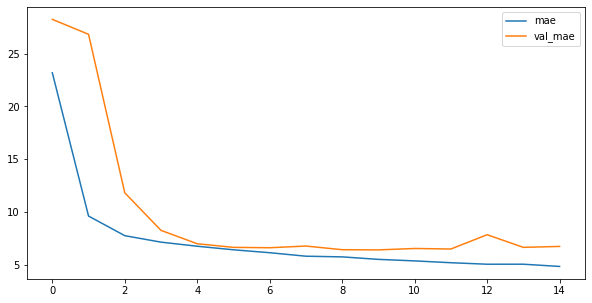

In [23]:
training_hist2 = pd.DataFrame(history2.history)

fig, ax = plt.subplots(1,1, figsize=(10,5))

training_hist2[['mae','val_mae']].plot(kind='line', ax=ax)
plt.show()

Indeed the pre-trained network perform much better with mae of 6.5 on validation set.